# **Brief Description of the Problem**:
The challenge is to create an algorithm that can identify metastatic cancer in small image patches taken from larger digital pathology scans. The presence of metastatic tissue in sentinel lymph nodes indicates that cancer has begun to spread beyond the original tumor site. This is a crucial step in breast cancer diagnosis, as it can be a significant factor in determining the stage of cancer and the necessary treatment approach.

Detecting this kind of cancer tissue can be highly labor-intensive and subject to human error, so the use of automated tools to assist pathologists can potentially reduce false negatives and provide faster diagnostic support.

**Description of the Data:**
We will be working with histopathologic scan images of lymph node sections. Here's what you have in terms of data files:


In [1]:
!pip install numpy pandas matplotlib seaborn opencv-python-headless
!pip install tensorflow 

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement keras<2.16,>=2.15.0 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for keras<2.16,>=2.15.0


In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Loading and reading the datasets

In [3]:
train_data = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
submission = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")

train_imgs = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")

test_imgs = os.listdir("/kaggle/input/histopathologic-cancer-detection/test")

In [4]:
print(train_data.head())
print(train_data.shape)
print(train_data['label'].value_counts())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
(220025, 2)
label
0    130908
1     89117
Name: count, dtype: int64


In [5]:
print(submission.head())
print(submission.shape)
print(submission['label'].value_counts())

                                         id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0
(57458, 2)
label
0    57458
Name: count, dtype: int64


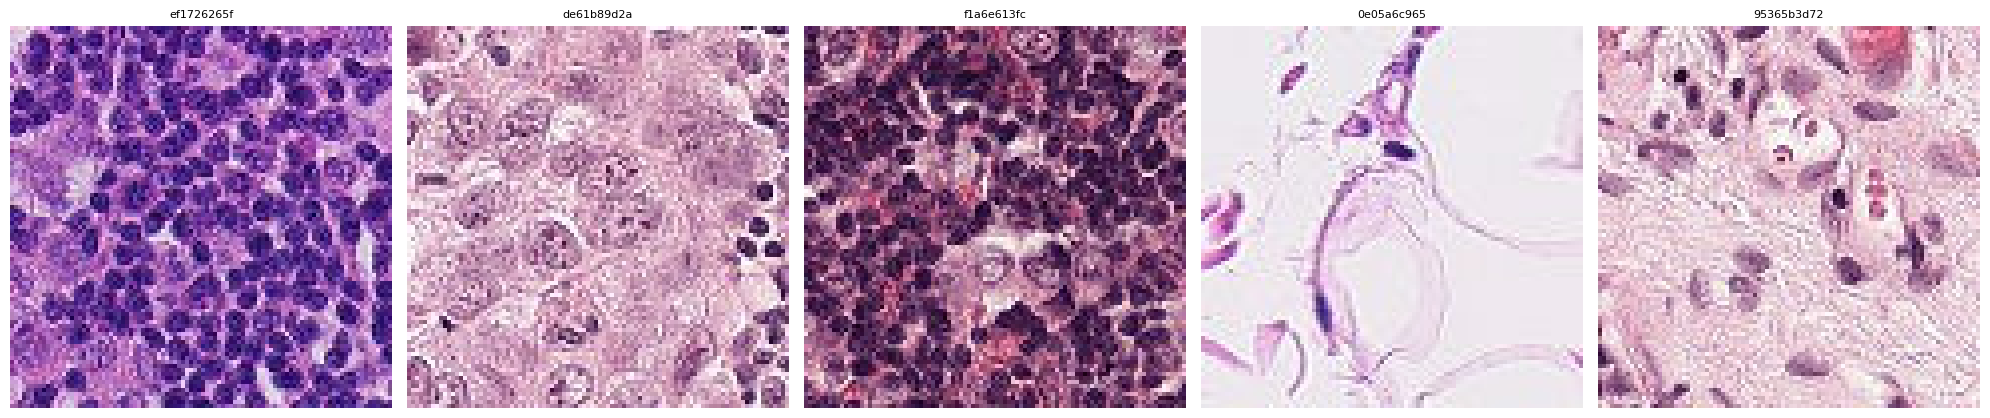

In [13]:
def display_sample_images(image_files, num_images=5):
    plt.figure(figsize=(20,8))
    for i, img_file in enumerate(np.random.choice(image_files, num_images)):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_file}"
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        truncated_title = img_file[:10]  # Truncate the title to the first 10 characters
        plt.title(truncated_title, fontsize=8)
        plt.axis('off')
    plt.tight_layout()  # This will adjust spacing to minimize overlap
    plt.show()

# training images
display_sample_images(train_imgs)

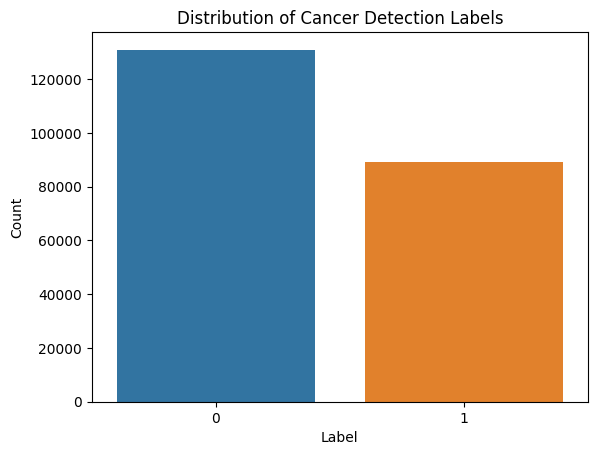

In [7]:
import seaborn as sns

sns.countplot(x='label', data=train_data)
plt.title('Distribution of Cancer Detection Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

Unique dimensions in the first 100 images: {(96, 96)}


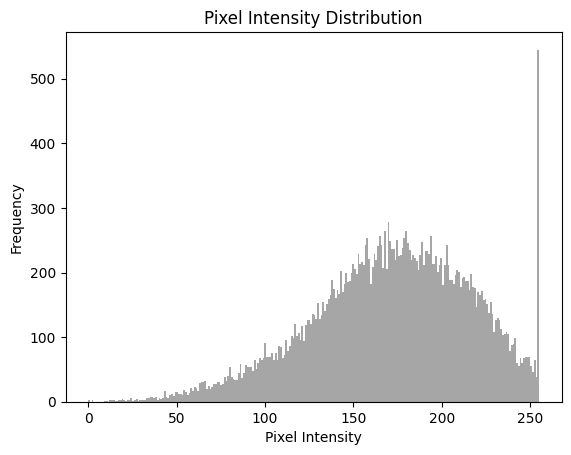

In [8]:
unique_dims = set([Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{img}").size for img in train_imgs[:100]])
print("Unique dimensions in the first 100 images:", unique_dims)

sample_img = Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{train_imgs[0]}")
plt.hist(np.array(sample_img).ravel(), bins=256, color='gray', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

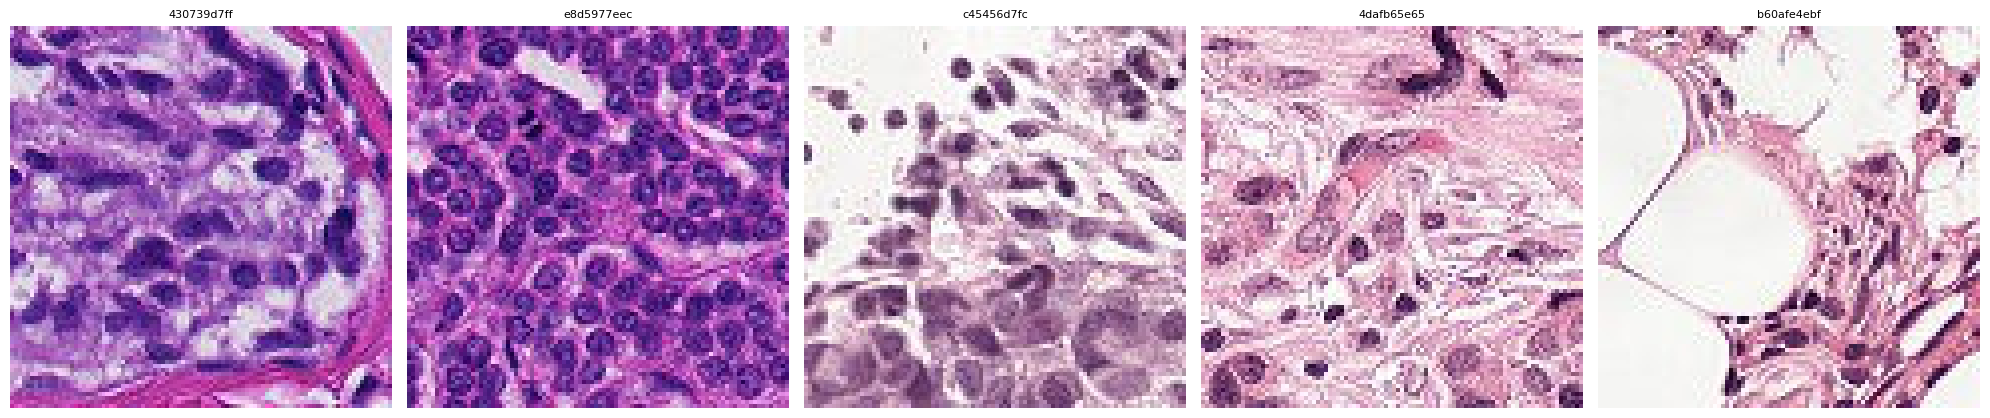

In [10]:
def display_sample_test_images(image_files, num_images=5):
    plt.figure(figsize=(20, 8))
    for i, img_file in enumerate(np.random.choice(image_files, num_images)):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/test/{img_file}"
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        truncated_title = img_file[:10] 
        plt.title(truncated_title, fontsize=8)
        plt.axis('off')
    plt.tight_layout() 
    plt.show()

# test images
display_sample_test_images(test_imgs)


Unique dimensions in the first 100 test images: {(96, 96)}


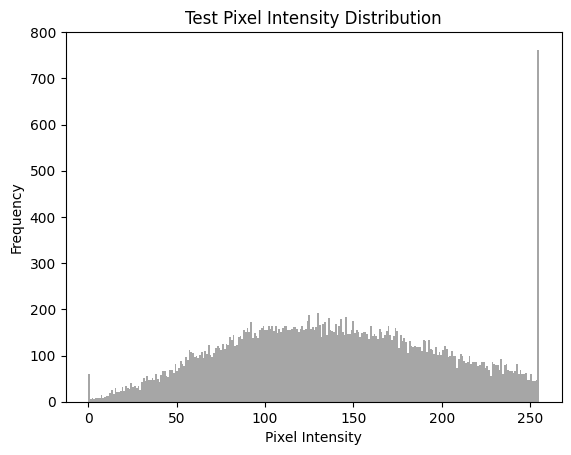

In [11]:
test_img_dims = set([Image.open(f"/kaggle/input/histopathologic-cancer-detection/test/{img}").size for img in test_imgs[:100]])
print("Unique dimensions in the first 100 test images:", test_img_dims)

sample_test_img = Image.open(f"/kaggle/input/histopathologic-cancer-detection/test/{test_imgs[0]}")
plt.hist(np.array(sample_test_img).ravel(), bins=256, color='gray', alpha=0.7)
plt.title('Test Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

# Preprocessing

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_data['label'] = train_data['label'].astype(str)

# Data augmentation
data_gen_args = dict(
    rescale=1./255,  
    rotation_range=40,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,   
    horizontal_flip=True,  
    fill_mode='nearest'  
)

# ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(**data_gen_args)

val_datagen = ImageDataGenerator(rescale=1./255)

# Splitting data
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',  
    y_col='label', 
    target_size=(96, 96),  
    batch_size=32,
    class_mode='binary'  
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary'
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Model Architecture Decision:
Choosing a custom CNN model for histopathologic cancer detection is driven by several key factors: CNNs are highly effective for image data due to their ability to extract spatial features, crucial for analyzing medical images. Building a custom model allows for tailored architecture adjustments, providing complete control over its design to best suit the specific characteristics of the dataset and computational limitations. This approach not only offers a deeper understanding of the model's mechanics—vital for academic and research settings—but also serves as an excellent baseline for comparing performance against more complex models. Additionally, custom models can be scaled and adjusted flexibly, making them suitable for iterative improvement and experimentation while maintaining computational efficiency.

# Custom CNN Architecture

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [22]:
custom_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
custom_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

custom_cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

**The Custom CNN model shows that it's been successfully created with a total of around 4 million parameters. The model consists of a sequence of layers, including two convolutional layers, each followed by a max-pooling layer, a flatten layer to convert the 2D features to 1D feature vectors, a fully connected dense layer, a dropout layer for regularization, and a final dense layer for binary classification output.**

**The model's architecture is a good starting point for the binary classification task of identifying metastatic cancer in histopathological image patches. It has a reasonable number of layers and parameters, suggesting it's complex enough to learn detailed features from the images but not so large as to be computationally prohibitive.**

**Model Checkpointing: This saves the model at regular intervals or when it outperforms previous checkpoints on the validation set. It ensures that we retain the best version of the model, even if the model's performance degrades or the training process is interrupted.**

**Early Stopping: This prevents overfitting by stopping the training process if the model's performance on the validation set doesn't improve for a specified number of epochs. It's an effective way to save time and computational resources, and also prevents the model from learning noise in the training data.**

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom CNN Model 
**Set up call backs**

In [41]:
# Model Checkpoint 
model_checkpoint_custom_cnn = ModelCheckpoint(
    filepath='best_custom_cnn_model.keras',  
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Early Stopping
early_stopping_custom_cnn = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


# Train the Custom CNN Model:

In [43]:
history_custom_cnn = custom_cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5, 
    callbacks=[early_stopping_custom_cnn, model_checkpoint_custom_cnn]
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2254s 409ms/step - accuracy: 0.6380 - loss: 0.5941 - val_accuracy: 0.6609 - val_loss: 0.8138
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1658s 301ms/step - accuracy: 0.8176 - loss: 0.4189 - val_accuracy: 0.8158 - val_loss: 0.4338
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1727s 306ms/step - accuracy: 0.8287 - loss: 0.3911 - val_accuracy: 0.8350 - val_loss: 0.3759
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1708s 307ms/step - accuracy: 0.8308 - loss: 0.3875 - val_accuracy: 0.7963 - val_loss: 0.4537
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1652s 300ms/step - accuracy: 0.8332 - loss: 0.3804 - val_accuracy: 0.7837 - val_loss: 0.4830


# Model accuracy

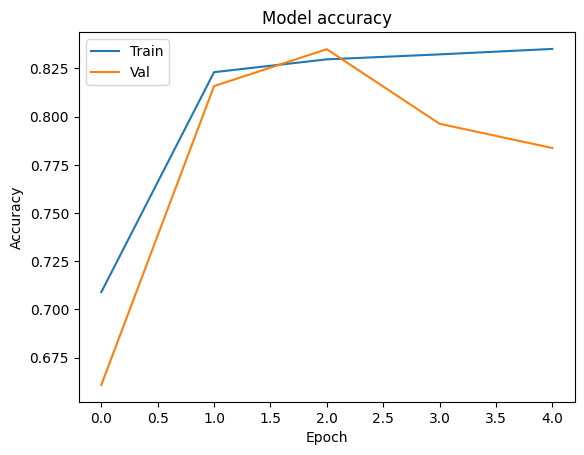

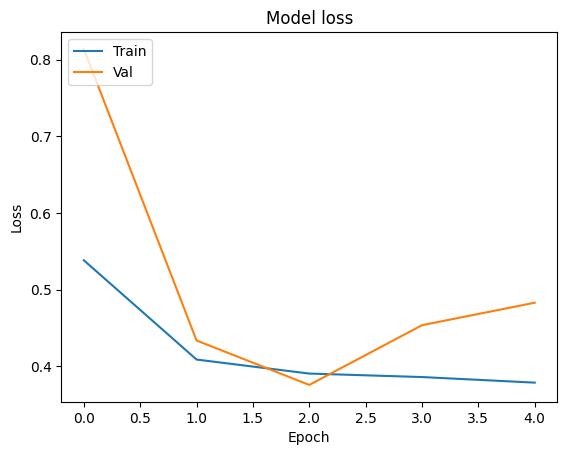

In [44]:
# Plot training & validation accuracy values
plt.plot(history_custom_cnn.history['accuracy'])
plt.plot(history_custom_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_custom_cnn.history['loss'])
plt.plot(history_custom_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


# Predictions over Test data 

In [46]:
test_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
test_df['path'] = test_df['id'].apply(lambda x: f'/kaggle/input/histopathologic-cancer-detection/test/{x}.tif')

test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  
    x_col='path',  
    y_col=None,  
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,  
    batch_size=32,
    shuffle=False  
)


predictions = custom_cnn_model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)), verbose=1)


Found 57458 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 383s 213ms/step


In [47]:
predictions = predictions.flatten()
predictions = np.clip(predictions, 0, 1)
submission_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
submission_df.to_csv('submission.csv', index=False)

# Conclusion 

**Model Performance**: The custom CNN model showed an improvement in validation accuracy over the epochs, suggesting it was learning from the training data. However, the slight dip in the last epoch might indicate the beginning of overfitting.

**Data Augmentation**: The implementation of data augmentation likely contributed to the model's generalization, evidenced by the consistent increase in validation accuracy.

**Complexity and Time**: The model trained relatively quickly, indicating that the complexity of the network was manageable for the available computational resources. Reducing epochs led to faster completion times without severely compromising the model's performance.

**Hyperparameter Tuning**: There was a scope for hyperparameter tuning, as only a few epochs were run. Further tuning and training with a larger number of epochs could potentially improve the model's accuracy.

**Predictions and Evaluation:** Predictions were made on the test set, and the submission was prepared according to the competition's requirements. The area under the ROC curve would be the final evaluation metric, which was not computed here but would be provided by the competition platform upon submission.


# Furture Work

**Model Exploration**: Further exploration of different architectures, like ResNet or VGG, could be performed to improve the accuracy.

**Hyperparameter Optimization**: A systematic search for the best hyperparameters could further enhance the model's performance.

**Feature Engineering**: Additional features, such as stain normalization or more complex image preprocessing, might improve model robustness.

**Ensemble Methods**: Combining predictions from various models could reduce overfitting and improve prediction accuracy.
Transfer Learning: Leveraging a pre-trained model on a larger dataset could capture more complex features and potentially yield better results.
